### Dataset Information

This MNIST dataset consists of 70000 images of handwritten digits where each digit of size 28 x 28 is flattened into a vector of size 784. These 70000 images are split into training set and testing set where the training set consists of 42000 images and the test set consists of 28000 images.

### Problem Statement
Correctly classify the digits from the dataset

### Overview
In this kernel, I first use 2D-DCT to reduce the dimension of the dataset. Two approaches are used to classify the dimension reduced datapoints - PCA and ANN. The classification is relatively faster as compared to the CNN approaches as now we are dealing with a vector for each data sample instead of an image.

### References
D. Ismailova and W. Lu, "Fast classification of handwritten digits using 2D-DCT based sparse PCA," 2015 IEEE Pacific Rim Conference on Communications, Computers and Signal Processing (PACRIM), 2015, pp. 131-135, doi: 10.1109/PACRIM.2015.7334822.

Please upvote if you like my work. Thank you!

# **1. Importing Libraries**

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.sparse.linalg.eigen.arpack import eigsh as largest_eigsh
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from tensorflow.keras.layers import Dense, Input, Conv1D,MaxPooling1D, GlobalMaxPooling1D, GaussianNoise, BatchNormalization,Flatten,Dropout
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical
from tensorflow.keras.optimizers import RMSprop, Adam


# **2. Data Handling and Exploration**

In [2]:
# load data set
train_data = pd.read_csv('../input/digit-recognizer/train.csv')
test_data = pd.read_csv('../input/digit-recognizer/test.csv')

In [3]:
train_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
test_data.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


For training set, the first column is the label. So we need to split the labels from the actual image data to perform classification. 

In [5]:
#Splitting labels from actual data
Xtrain = train_data.iloc[:,1:]
ytrain = train_data.iloc[:,0]
Xtest = test_data

In [6]:
#Overview of the dataset
num_pixels = len(Xtrain.loc[0])
img_dim = np.sqrt(num_pixels).astype(int)
num_classes = len(set(ytrain))
num_samples = len(Xtrain)
num_samples_te = len(Xtest)
print(10*"-","Overview of the Dataset",10*"-")
print("Size of each image: {} x {}".format(img_dim,img_dim))
print("Number of pixels in each image:",num_pixels)
print("Number of classes:",num_classes)
print("Number of images in the training set:",num_samples)
print("Number of images in the testing set:",num_samples_te)

---------- Overview of the Dataset ----------
Size of each image: 28 x 28
Number of pixels in each image: 784
Number of classes: 10
Number of images in the training set: 42000
Number of images in the testing set: 28000


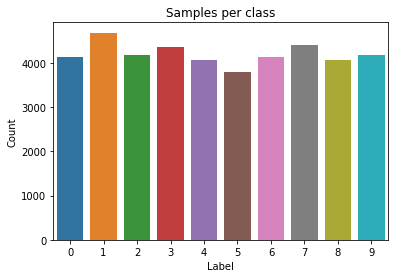

In [7]:
#samples per class
sample_per_class = np.unique(ytrain,return_counts = True)
sns.barplot( x = sample_per_class[0], y = sample_per_class[1])
plt.title('Samples per class')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [8]:
for m,n in zip(sample_per_class[0],sample_per_class[1]):
    print("Number of samples for {} : {} ".format(m,n))

Number of samples for 0 : 4132 
Number of samples for 1 : 4684 
Number of samples for 2 : 4177 
Number of samples for 3 : 4351 
Number of samples for 4 : 4072 
Number of samples for 5 : 3795 
Number of samples for 6 : 4137 
Number of samples for 7 : 4401 
Number of samples for 8 : 4063 
Number of samples for 9 : 4188 


The dataset appears to be fairly balanced

In [9]:
# Normalization
Xtrain = Xtrain / 255.0
Xtest = Xtest / 255.0

Normalization is performed to reduce illumination differences

In [10]:
#Splitting the training data into training and validation set
Xtrain,Xval,ytrain,yval = train_test_split(Xtrain,ytrain,test_size = 0.2,random_state = 2)

In [11]:
#Reshaping Xtrain and Xtest
Xtrain  = Xtrain.to_numpy().reshape(-1,28,28)
Xval = Xval.to_numpy().reshape(-1,28,28)
ytrain  = ytrain.to_numpy()
Xtest = Xtest.to_numpy().reshape(-1,28,28)

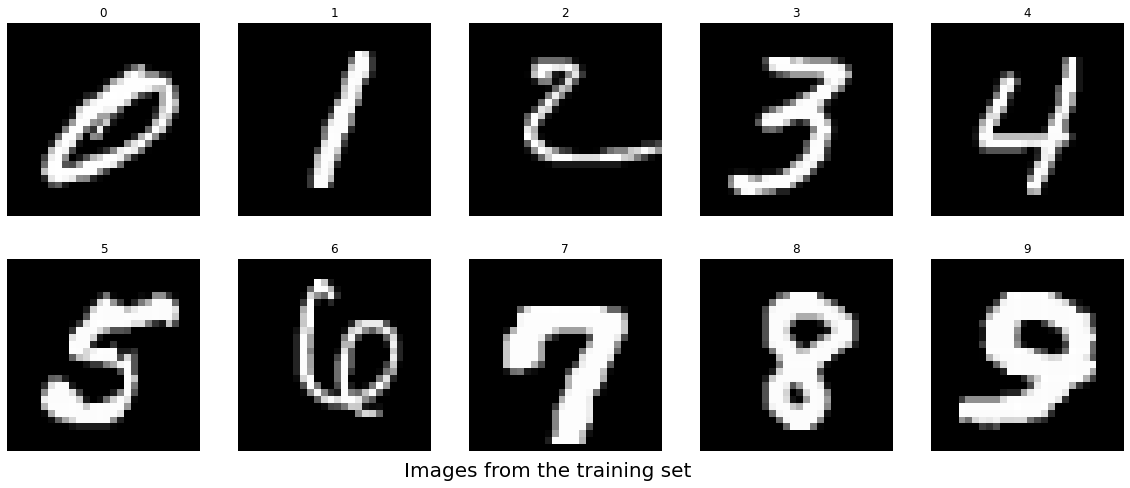

In [12]:
#Plotting images for each sign
plt.figure(figsize=(20,6))

for i,j in enumerate([4,7,0,1,14,9,32,5,8,3]):
    plt.subplot(2,5,i+1)
    plt.subplots_adjust(top = 2, bottom = 1)
    img = Xtrain[j]
    img = img.reshape((28,28))
    plt.imshow(img,cmap = 'gray')
    plt.title(ytrain[j])
    plt.axis('off')
plt.suptitle('Images from the training set',fontsize = 20)
plt.show()

# **3. Dimension reduction using DCT**

The 2D Discrete Cosine Transform (DCT) can be effectively used to compress digital images. The 2D DCT removes redundancies between neighbouring pixels and gives us uncorrelated transform coefficients which can be independently encoded. The DCT has a variety of useful properties such as energy preservability, compaction, seperability and decorrelation ability that makes it suitable for compression. 

For dimensionality reduction, the energy compaction and signal decorrelation property of 2D DCT is very useful which allows representation of digital image by a relatively small number of DCT coefficients. To achieve this, zig zag scanning is used to scan each digit image of the data base of size 28 x 28 from top-left to bottom-right converting it into a vector of length 784. The DCT coefficients with larger magnitude tend to occur in the top-left corner. Hence, in a vector obtained by zig-zag scanning from top-left, larger DCT coefficients will be concentrated in the top part of the vector. Therefore, it is possible to get a fairly accurate estimation of the raw input image using a low dimensional vector obtained by retaining only the first several DCT coefficients.

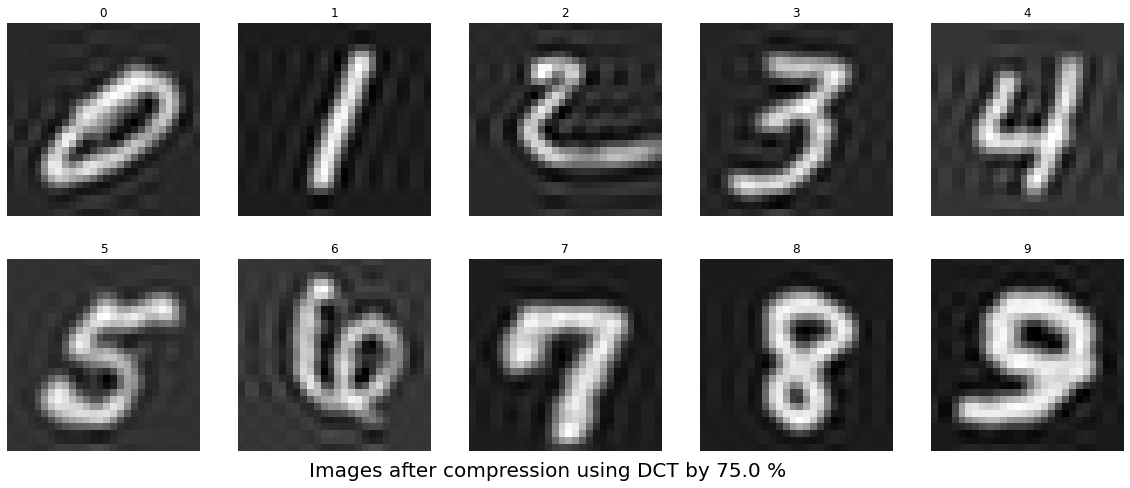

In [13]:
#Lets plot the images compressed using DCT
n_coeff = 14 #retaining only 14 x 14 DCT coefficients of a 28 x 28 image
compress = np.round((1-(n_coeff**2/num_pixels))*100,2)
plt.figure(figsize=(20,6))
for i,j in enumerate([4,7,0,1,14,9,32,5,8,3]):
    plt.subplot(2,5,i+1)
    plt.subplots_adjust(top = 2, bottom = 1)
    C = cv2.dct(Xtrain[j]) #dct of image
    C_ = C[0:n_coeff,0:n_coeff] #taking only 30 x 30 i.e. 900 coefficients
    C_n = np.zeros([28,28]) #original image shape
    C_n[0:n_coeff,0:n_coeff] = C_
    X_n = cv2.idct(C_n)
    plt.imshow(X_n,cmap = 'gray')
    plt.title(ytrain[j])
    plt.axis('off')
plt.suptitle('Images after compression using DCT by {} %'.format(compress),fontsize = 20)
plt.show()

In [14]:
#function for zigzag scanning
def zigzag(a):
    b =  np.concatenate([np.diagonal(a[::-1,:], i)[::(2*(i % 2)-1)] for i in range(1-a.shape[0], a.shape[0])])
    return b

In [15]:
def dct_reduce(img,n):
    #n is determine using how much energy we wanna retain
    C = cv2.dct(img) #Perform discrete cosine transfor
    c = zigzag(C) #scans image from top left to bottom right
    s = c[:n] #retains first n entries
    return s

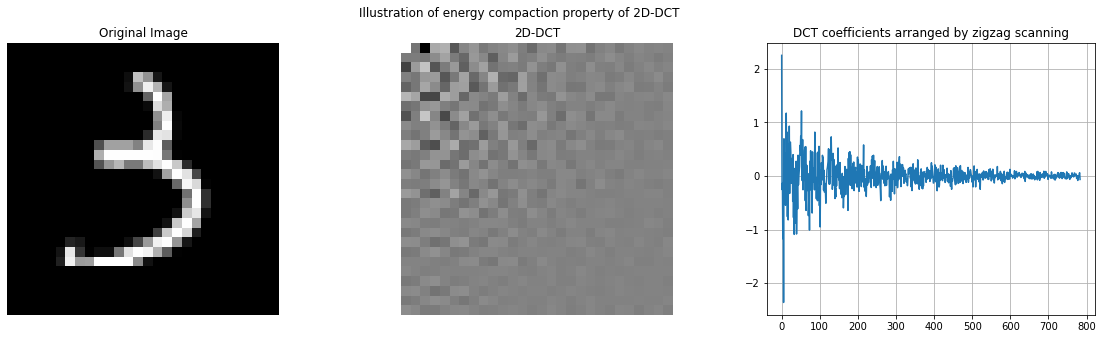

In [16]:
r = np.random.choice(range(len(Xtrain)))
I = Xtrain[r,:,:] #select a random image
C = cv2.dct(I) #calculate dct
c = zigzag(C) #perform zigzag scanning
fig,ax = plt.subplots(1,3,figsize=(20,5))
ax[0].imshow(I,cmap = 'gray') #original image
ax[0].set_title('Original Image')
ax[0].axis('off')
ax[1].imshow(C,cmap = 'gray')
ax[1].set_title('2D-DCT')
ax[1].axis('off')
ax[2].plot(c)
ax[2].grid(True)
ax[2].set_title('DCT coefficients arranged by zigzag scanning')
plt.suptitle('Illustration of energy compaction property of 2D-DCT')
plt.show()

In [17]:
n =   196 #retaining only first 196 coefficients
E_i = np.round(np.linalg.norm(I),2)  #frobenius norm of matrix after flattening
E_c = np.round(np.linalg.norm(C),2)
E_cr = np.round(np.linalg.norm(zigzag(C)[:n]),2)
e_ret = E_cr/E_c*100
print("Frobenius norm of Image and its DCT is {} and {} respectively".format(E_i,E_c))
print("Frobenius norm with only {} coefficients: {}".format(n,E_cr))
print('Percentage of energy retained: {} %'.format(np.round(e_ret,2)))

Frobenius norm of Image and its DCT is 7.04 and 7.04 respectively
Frobenius norm with only 196 coefficients: 6.49
Percentage of energy retained: 92.19 %


In [18]:
#Perform DCT based dimension reduction on train set
xtrain = np.zeros([len(Xtrain),n])
for i in range(len(Xtrain)):
    Itr = Xtrain[i]
    s_tr = dct_reduce(Itr,n)
    xtrain[i] = s_tr #truncated 
    

In [19]:
#Perform DCT based dimension reduction on validation set
xval = np.zeros([len(Xval),n])
for i in range(len(Xval)):
    Ival = Xval[i]
    s_val = dct_reduce(Ival,n)
    xval[i] = s_val

In [20]:
#Perform DCT based dimension reduction on test set
xtest = np.zeros([len(Xtest),n])
for i in range(len(Xtest)):
    Itest = Xtest[i]
    s_test = dct_reduce(Itest,n)
    xtest[i] = s_test

# **4. Performing Classification**

### Using PCA for Classification

In [21]:
def PCA_extract(xtrain,ytrain,q):
    # q  - number of principal component components to be retained .
    U = []
    M = []
    for i in range(ytrain.max()+1):
        D = xtrain[np.where(ytrain == i)]  #get data for each digit
        m = np.mean(D, axis=0) #calculate the mean of each column
        C = D - m #centralize each data point
        V = np.cov(C.T) #calculate covariance
        # eigendecomposition of covariance matrix
        values, vectors = largest_eigsh(V,q,which = 'LM') # we want q eigen vectors corresponding to q largest magnitude eigen values
        U.append(vectors)
        M.append(m)  
    return U,M

In [22]:
q = 14
U,M = PCA_extract(xtrain,ytrain,q)

In [23]:
# Perform classification using PCA
def PCA_classify(test,U,M):
    e = np.zeros([len(test),10])
    for i in range(len(test)):
        for j in range(10):
            Uq = U[j] #get the eigen vector corresponding to the class (n x q)
            te = test[i] - M[j] # (n,)
            f =  np.dot(Uq.T,te) #lower dimension of the point (q x n)*(n x 1) = q x 1
            z = np.dot(f,Uq.T) # projecting low dimensional data point onto subspace of each class
            d = np.linalg.norm(z - te) #distance between testing datapoint and its projection
            e[i,j]= d
    # identify the target class for data points 
    ypred = np.argmin(e,axis =1 ) 
    return ypred

In [24]:
#classification on the validation set
ypred = PCA_classify(xval,U,M)

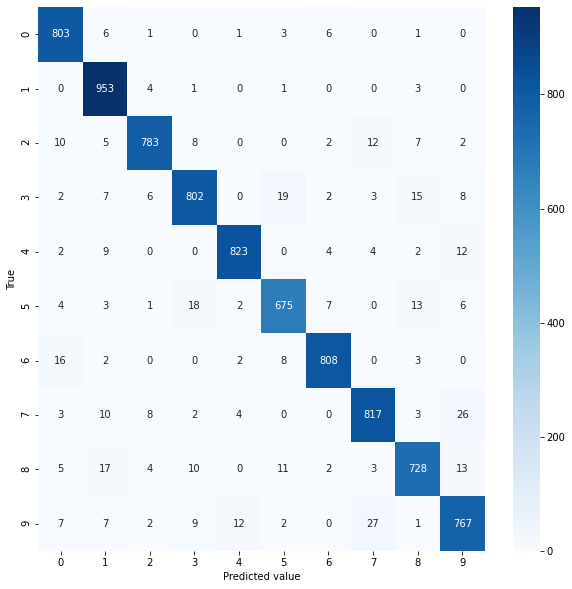

In [25]:
#plot confusion matrix
cm = confusion_matrix(yval,ypred)
plt.figure(figsize=(10,10))
sns.heatmap(cm,cmap = 'Blues',annot = True,fmt = 'g')
plt.xlabel('Predicted value')
plt.ylabel('True')
plt.show()

In [26]:
accuracy = np.round(accuracy_score(yval,ypred),4)
print("The accuracy of PCA based classifier on validation set is {} %".format(accuracy*100))

The accuracy of PCA based classifier on validation set is 94.75 %


In [27]:
#classification on the test set
ypred_t = PCA_classify(xtest,U,M)

In [28]:
results = pd.Series(ypred_t,name="Label")
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv("dct_pca_mnist.csv",index=False)

### Using ANN for classification

In [29]:
def plotLearningCurve(history,epochs):
  epochRange = range(1,epochs+1)
  fig , ax = plt.subplots(1,2,figsize = (10,5))
  
  ax[0].plot(epochRange,history.history['accuracy'],label = 'Training Accuracy')
  ax[0].plot(epochRange,history.history['val_accuracy'],label = 'Validation Accuracy')
  ax[0].set_title('Training and Validation accuracy')
  ax[0].set_xlabel('Epoch')
  ax[0].set_ylabel('Accuracy')
  ax[0].legend()
  ax[1].plot(epochRange,history.history['loss'],label = 'Training Loss')
  ax[1].plot(epochRange,history.history['val_loss'],label = 'Validation Loss')
  ax[1].set_title('Training and Validation loss')
  ax[1].set_xlabel('Epoch')
  ax[1].set_ylabel('Loss')
  ax[1].legend()
  fig.tight_layout()
  plt.show()

In [30]:
np.random.seed(12)
i = Input(shape=len(xtrain.T))
x = Dense(256, activation='relu')(i)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(32,activation = 'relu')(x)
x = Dropout(0.1)(x)
x = Dense(10, activation='softmax')(x)
model = Model(i, x)
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 196)]             0         
_________________________________________________________________
dense (Dense)                (None, 256)               50432     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0     

In [31]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(0.001),metrics=['accuracy']) # use categorical_crossentropy when one hot encoding is used

In [32]:
 r  = model.fit(x=xtrain, 
          y=ytrain, 
          epochs=10,
          batch_size = 16,
          validation_data=(xval, yval),
          )

Epoch 1/10
2100/2100 [==============================] - 6s 2ms/step - loss: 0.8870 - accuracy: 0.7056 - val_loss: 0.1842 - val_accuracy: 0.9468
Epoch 2/10
2100/2100 [==============================] - 4s 2ms/step - loss: 0.2677 - accuracy: 0.9270 - val_loss: 0.1436 - val_accuracy: 0.9575
Epoch 3/10
2100/2100 [==============================] - 4s 2ms/step - loss: 0.2114 - accuracy: 0.9419 - val_loss: 0.1234 - val_accuracy: 0.9651
Epoch 4/10
2100/2100 [==============================] - 4s 2ms/step - loss: 0.1705 - accuracy: 0.9541 - val_loss: 0.1107 - val_accuracy: 0.9688
Epoch 5/10
2100/2100 [==============================] - 4s 2ms/step - loss: 0.1543 - accuracy: 0.9579 - val_loss: 0.1061 - val_accuracy: 0.9677
Epoch 6/10
2100/2100 [==============================] - 4s 2ms/step - loss: 0.1436 - accuracy: 0.9618 - val_loss: 0.1044 - val_accuracy: 0.9702
Epoch 7/10
2100/2100 [==============================] - 4s 2ms/step - loss: 0.1293 - accuracy: 0.9646 - val_loss: 0.0956 - val_accuracy:

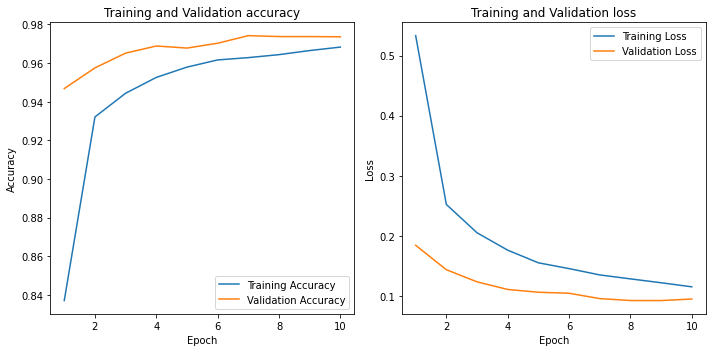

In [33]:
plotLearningCurve(r,10)

In [34]:
ypred = model.predict(xval)
ypred = np.argmax(ypred,axis = 1) 

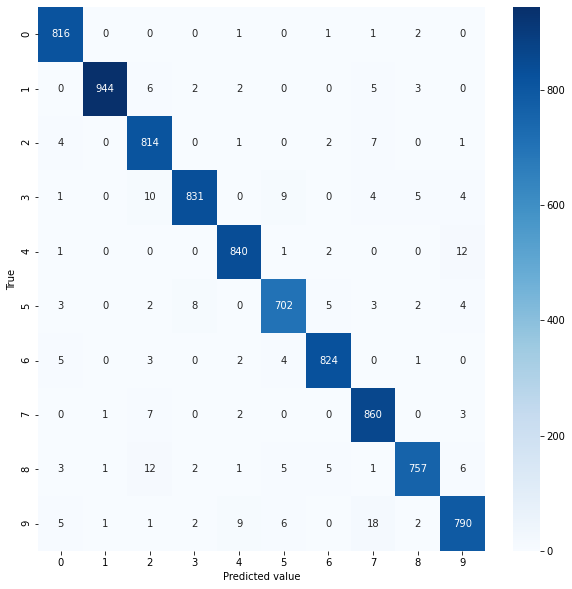

In [35]:
#plot confusion matrix
cm = confusion_matrix(yval,ypred)
plt.figure(figsize=(10,10))
sns.heatmap(cm,cmap = 'Blues',annot = True,fmt = 'g')
plt.xlabel('Predicted value')
plt.ylabel('True')
plt.show()

In [36]:
print("Train score:", model.evaluate(xtrain,ytrain))
print("Validation score:", model.evaluate(xval,yval))

1050/1050 [==============================] - 2s 2ms/step - loss: 0.0412 - accuracy: 0.9878
Train score: [0.04115181788802147, 0.9877678751945496]
263/263 [==============================] - 1s 2ms/step - loss: 0.0948 - accuracy: 0.9736
Validation score: [0.09483513981103897, 0.9735714197158813]


In [37]:
accuracy = np.round(accuracy_score(yval,ypred),4)
print("The accuracy of ANN on validation set is {} %".format(accuracy*100))

The accuracy of ANN on validation set is 97.36 %


In [38]:
ypred_t = model.predict(xtest)

In [39]:
# select the indix with the maximum probability
results = np.argmax(ypred_t,axis = 1)

results = pd.Series(results,name="Label")

In [40]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("dct_ann_mnist.csv",index=False)